# Audio Classifier for Capuchin Bird Calls

In [1]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import torchaudio
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchinfo import summary
from tqdm.auto import tqdm
from torchmetrics.classification import BinaryConfusionMatrix

In [2]:
sns.set_theme()
torch.__version__, torchaudio.__version__, torchvision.__version__

('2.3.1', '2.3.1', '0.18.1')

In [3]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    device = "mps"  # Apple GPU
else:
    device = "cpu"  # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: cuda


In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [5]:
WORKERS = 0

## Directories and File Paths

In [6]:
DATA_FOLDER = Path("../data")
CAPUCHIN_CLIPS_FOLDER = DATA_FOLDER / "Parsed_Capuchinbird_Clips"
NOT_CAPUCHIN_CLIPS_FOLDER = DATA_FOLDER / "Parsed_Not_Capuchinbird_Clips"
CAPUCHIN_CLIPS_FOLDER.exists(), NOT_CAPUCHIN_CLIPS_FOLDER.exists()

(True, True)

### Finding average clip length after resampling

In [7]:
SAMPLE_RATE = 16000
capuchin_clips_paths = list(CAPUCHIN_CLIPS_FOLDER.iterdir())
clips = [torchaudio.load(pth) for pth in capuchin_clips_paths]
resampled_clips = [
    torchaudio.functional.resample(d[0], d[1], SAMPLE_RATE) for d in clips
]
capuchin_clip_lengths = [clip.shape[1] for clip in resampled_clips]
print(f"Maximum num of frames in capuchin clip {np.amax(capuchin_clip_lengths)}")
print(f"Average num of frames in capuchin clip {np.mean(capuchin_clip_lengths)}")
print(f"Minimum num of frames in capuchin clip {np.amin(capuchin_clip_lengths)}")

Maximum num of frames in capuchin clip 80000
Average num of frames in capuchin clip 54156.6866359447
Minimum num of frames in capuchin clip 32000


In [8]:
NUM_FRAMES = 48000

## Creating Custom PyTorch Dataset

In [9]:
class CapuchinBirdCallDataset(Dataset):
    def __init__(
        self,
        positive_folder: Path,
        negative_folder: Path,
        sample_rate: int,
        num_frames: int,
    ) -> None:
        super().__init__()
        self.sample_rate = sample_rate
        self.num_frames = num_frames
        # load all clip paths into single sorted list
        positive_clips = list(positive_folder.iterdir())
        negative_clips = list(negative_folder.iterdir())
        clips = [
            (clip_path, torch.ones(1, dtype=torch.float32))
            for clip_path in positive_clips
        ]
        clips.extend(
            [
                (clip_path, torch.zeros(1, dtype=torch.float32))
                for clip_path in negative_clips
            ]
        )
        clips.sort(key=lambda item: item[0])
        self.clips = clips

        self.gen_spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=64, hop_length=128
        )

        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

    def load_mono_audio(self, clip_path: Path) -> torch.Tensor:
        clip_waveform, clip_sample_rate = torchaudio.load(clip_path)
        # only get the first channel
        clip_waveform = clip_waveform[0, :].unsqueeze(0)
        # resample the clip
        resampled_clip = torchaudio.functional.resample(
            clip_waveform, clip_sample_rate, self.sample_rate
        )
        resampled_clip = resampled_clip[:, : self.num_frames]
        # pad the clip if necessary
        if resampled_clip.shape[1] < self.num_frames:
            zero_padding = torch.zeros((1, self.num_frames - resampled_clip.shape[1]))
            resampled_clip = torch.concat((resampled_clip, zero_padding), dim=1)
        return resampled_clip

    def __len__(self) -> int:
        return len(self.clips)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        clip_path, label = self.clips[index]
        resampled_clip = self.load_mono_audio(clip_path)
        spectrogram = self.amplitude_to_db(self.gen_spectrogram(resampled_clip))
        # stack the spectrogram for rgb input
        spectrogram = spectrogram.expand(3, -1, -1)
        return spectrogram, label

### Spectrogram Sample of Capuchin Bird

In [10]:
capuchin_call_dataset = CapuchinBirdCallDataset(
    CAPUCHIN_CLIPS_FOLDER, NOT_CAPUCHIN_CLIPS_FOLDER, SAMPLE_RATE, NUM_FRAMES
)

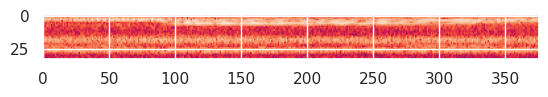

In [11]:
sample = capuchin_call_dataset.__getitem__(3)
plt.imshow(sample[0][0].squeeze().numpy())
plt.show()

## Creating train and test dataloaders

In [12]:
train_test_split_generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(
    capuchin_call_dataset, [0.8, 0.2], generator=train_test_split_generator
)

In [13]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=32, num_workers=WORKERS, shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=32, num_workers=0, shuffle=True
)
len(train_dataloader), len(test_dataloader)

(21, 6)

In [14]:
spectrogram_sample, label_sample = next(iter(train_dataloader))
spectrogram_sample.shape, label_sample.shape

(torch.Size([32, 3, 33, 376]), torch.Size([32, 1]))

In [15]:
input_shape = spectrogram_sample.shape

## Creating the model

In [16]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

### Freezing the base model and changing the classifier for our needs

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
output_shape = 1

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=500, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=500, out_features=1, bias=True),
).to(device)

In [19]:
summary(
    model=model,
    input_size=input_shape,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 33, 376]     [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 33, 376]     [32, 1280, 2, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 33, 376]     [32, 32, 17, 188]    --                   False
│    │    └─Conv2d (0)                                       [32, 3, 33, 376]     [32, 32, 17, 188]    (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 17, 188]    [32, 32, 17, 188]    (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 17, 188]    [32, 32, 17, 188]    --                   --
│    └─Sequential (1)                                        [32, 32, 17, 188]    [32, 

## Training the model

In [20]:
# Define loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
torch.manual_seed(42)
epochs = 18

# Create training and testing loop
for epoch in range(epochs + 1):
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for X, y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            X = X.to(device)
            y = y.to(device)

            model.train()

            y_logits = model(X)

            loss = loss_fn(y_logits, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        ### Testing
        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)

            test_loss /= len(test_dataloader)
        print(f"Epoch: {epoch} | Test loss: {test_loss}")

  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 0 | Test loss: 0.4964410662651062


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 1 | Test loss: 0.2002078890800476


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 2 | Test loss: 0.15259897708892822


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 3 | Test loss: 0.18436257541179657


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 4 | Test loss: 0.07324954122304916


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 5 | Test loss: 0.0635937750339508


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 6 | Test loss: 0.06685509532690048


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 7 | Test loss: 0.10896728932857513


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 8 | Test loss: 0.07034129649400711


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 9 | Test loss: 0.0627288669347763


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 10 | Test loss: 0.0554388090968132


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 11 | Test loss: 0.07191538065671921


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 12 | Test loss: 0.06309047341346741


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 13 | Test loss: 0.07901588827371597


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 14 | Test loss: 0.04686073213815689


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 15 | Test loss: 0.04329266399145126


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 16 | Test loss: 0.10714493691921234


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 17 | Test loss: 0.08215902745723724


  0%|          | 0/21 [00:00<?, ?batch/s]

Epoch: 18 | Test loss: 0.03864150494337082


## Evaluating the model

In [22]:
X_test, y_test = next(iter(test_dataloader))
X_test, y_test = X_test.to(device), y_test.to(device)
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)

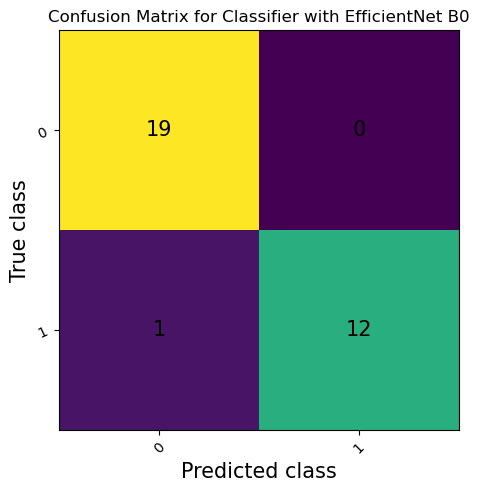

In [23]:
bcm = BinaryConfusionMatrix()
bcm(y_logits.cpu(), y_test.cpu())
bcm.plot()
plt.title("Confusion Matrix for Classifier with EfficientNet B0")
plt.show()